In [ ]:
# Import the things we need
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import stan as pystan
import arviz as az
import math
from IPython.display import Latex

import nest_asyncio
nest_asyncio.apply()

In [ ]:
# Load in the data
df = pd.read_csv('../data/eurovision_merged_covariates_03Feb.csv')
df.head()

In [ ]:
# Get the full set of country codes
countries = df['From country'].unique()
print('Number of countries: {}'.format(len(countries)))

In [ ]:
# Load the codes pickle so we can convert to proper names
with open('../data/country_codes_dict.pickle', 'rb') as f:
    codes = pickle.load(f)
# Reverse the keys and values
codes = {y: x.title() for x, y in codes.items()}
print('Number of codes: {}'.format(len(codes)))

Standardise the votes:
$$
\alpha^*_{\text{vp}} = \frac{\alpha_{vp} - \bar{\alpha}}{s_\alpha}
$$

In [ ]:
# Calculate the mean and standard error
mean = df['Votes'].mean()
se = df['Votes'].std()

Latex(f"""\\begin{{align*}}
\\bar{{\\alpha}} &= {mean}, \\\\
s_\\alpha &= {se}.
\\end{{align*}}
""")

In [ ]:
# Strip out the data we don't need
standardised = pd.DataFrame(df, columns=['From country', 'code', 'Votes'])

# Insert the alpha* variables
standardised['performer'] = df['code']
standardised['voter'] = df['From country']
standardised['alpha*'] = (df['Votes'] - mean) / se
standardised = pd.DataFrame(standardised, columns=['voter', 'performer', 'alpha*'])
standardised.head()

In [ ]:
# Define the stan model

# Obviously this is nonsense...

code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

In [ ]:
# Define a function for generating the forest plot
def plot_distribution(voter):
    # Calculate means and performers that actually received votes (recipients)
    recipients = []

    means = []
    for country in countries:
        mean = standardised.loc[(standardised['voter'] == voter) & (standardised['performer'] == country)]['alpha*'].mean()
        if not math.isnan(mean):
            recipients.append(country)
            means.append(mean)
    
    # Calculate the standard errors
    stes = []
    for country in recipients:
        ste = standardised.loc[(standardised['voter'] == voter) & (standardised['performer'] == country)]['alpha*'].std()
        stes.append(ste)
    
    # Populate the stan data
    data = {
        "J": len(means),
        "y": np.array(means),
        "sigma": np.array(stes),
    }

    # Build and run the stan model
    posterior = pystan.build(code, data=data, random_seed=1)
    fit = posterior.sample(num_chains=4, num_samples=1000)

    # Import the stan model into Arviz
    stan_data = az.from_pystan(
        posterior=fit,
        posterior_predictive="y_hat",
        observed_data=["y"],
        log_likelihood={"y": "log_lik"},
        coords={"performer": [codes[recipient] for recipient in recipients]},
        dims={
            "theta": ["performer"],
            "y": ["performer"],
            "log_lik": ["performer"],
            "y_hat": ["performer"],
            "theta_tilde": ["performer"],
        },
    )

    # Render a forest plot of the posterior model
    means_order = stan_data.posterior["theta"].mean(("chain", "draw"))
    order = stan_data.posterior["performer"].sortby(means_order)[::-1]

    axes = az.plot_forest(stan_data.posterior.sel(performer=order), combined=True, var_names=["theta"], labeller=az.labels.NoVarLabeller(), textsize=8, colors='#323296')
    axes[0].set_title('Vote distribution for {}'.format(codes[voter]))
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(x=1.96, color='black', linestyle=':', linewidth=0.5)
    plt.axvline(x=-1.96, color='black', linestyle=':', linewidth=0.5)
    plt.show()

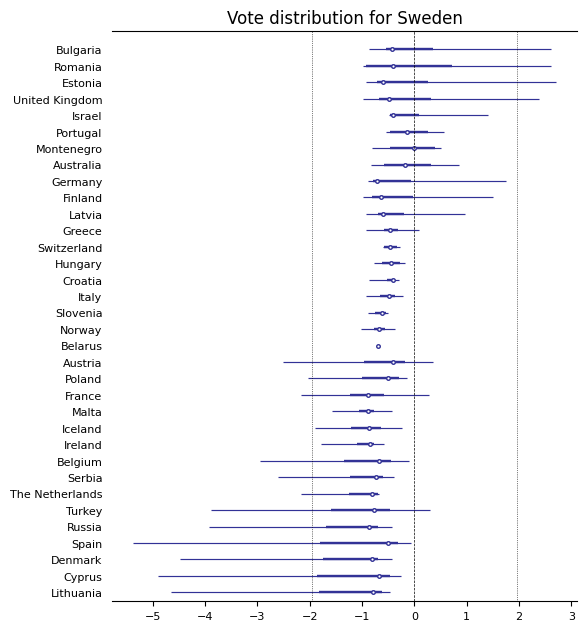

In [9]:
%%capture --no-display

# Forest plot for Sweden
plot_distribution('SE')